# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-34-47/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5396 | MulticlassF1Score=0.0679
Batch-30 : CrossEntropyLoss=2.4705 | MulticlassF1Score=0.1572
Batch-45 : CrossEntropyLoss=2.4597 | MulticlassF1Score=0.2249
Batch-60 : CrossEntropyLoss=2.4119 | MulticlassF1Score=0.2869
Batch-75 : CrossEntropyLoss=2.3875 | MulticlassF1Score=0.3421
Batch-90 : CrossEntropyLoss=2.3643 | MulticlassF1Score=0.3837
Batch-105: CrossEntropyLoss=2.3714 | MulticlassF1Score=0.4153
Batch-120: CrossEntropyLoss=2.3435 | MulticlassF1Score=0.4433
Batch-135: CrossEntropyLoss=2.3341 | MulticlassF1Score=0.4695
Batch-150: CrossEntropyLoss=2.3508 | MulticlassF1Score=0.4891
Batch-165: CrossEntropyLoss=2.3520 | MulticlassF1Score=0.5087
Batch-180: CrossEntropyLoss=2.3403 | MulticlassF1Score=0.5255
Batch-195: CrossEntropyLoss=2.3295 | MulticlassF1Score=0.5399
Batch-210: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.5532
Batch-225: CrossEntropyLoss=2.3271 | MulticlassF1Score=0.5654
Batch-226: CrossEntropyLoss=2.3276 | MulticlassF1Score=0.5658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3242 | MulticlassF1Score=0.7393
Batch-30 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7423
Batch-45 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7391
Batch-60 : CrossEntropyLoss=2.3395 | MulticlassF1Score=0.7391
Batch-63 : CrossEntropyLoss=2.3352 | MulticlassF1Score=0.7393

Training   : Mean CrossEntropyLoss = 2.3932 | Mean MulticlassF1Score = 0.3826
Validation : Mean CrossEntropyLoss = 2.3302 | Mean MulticlassF1Score = 0.7397

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3228 | MulticlassF1Score=0.7513
Batch-30 : CrossEntropyLoss=2.3377 | MulticlassF1Score=0.7465
Batch-45 : CrossEntropyLoss=2.3301 | MulticlassF1Score=0.7439
Batch-60 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7434
Batch-75 : CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7440
Batch-90 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7452
Batch-105: CrossEntropyLoss=2.3289 | MulticlassF1Score=0.7448
Batch-120: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.7454
Batch-135: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7478
Batch-150: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7521
Batch-165: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7555
Batch-180: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7585
Batch-195: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7611
Batch-210: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.7634
Batch-225: CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7643
Batch-226: CrossEntropyLoss=2.3071 | MulticlassF1Score=0.7644

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7962
Batch-30 : CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7897
Batch-45 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7898
Batch-60 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7900
Batch-63 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7896

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3214 | Mean MulticlassF1Score = 0.7503
Validation : Mean CrossEntropyLoss = 2.3140 | Mean MulticlassF1Score = 0.7913

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7926
Batch-30 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7923
Batch-45 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7937
Batch-60 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7953
Batch-75 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7992
Batch-90 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7996
Batch-105: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8002
Batch-120: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.8007
Batch-135: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8008
Batch-150: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8016
Batch-165: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8019
Batch-180: CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8031
Batch-195: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8033
Batch-210: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.8030
Batch-225: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.8033
Batch-226: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8051
Batch-30 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8062
Batch-45 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8066
Batch-60 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.8069
Batch-63 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8064

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3089 | Mean MulticlassF1Score = 0.7987
Validation : Mean CrossEntropyLoss = 2.3083 | Mean MulticlassF1Score = 0.8066

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8099
Batch-30 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8099
Batch-45 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8064
Batch-60 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8069
Batch-75 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.8070
Batch-90 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8080
Batch-105: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8084
Batch-120: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8087
Batch-135: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8084
Batch-150: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.8083
Batch-165: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8086
Batch-180: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8089
Batch-195: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8092
Batch-210: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8105
Batch-225: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8116
Batch-226: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8116

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8288
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8259
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8259
Batch-60 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8262
Batch-63 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3061 | Mean MulticlassF1Score = 0.8079
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8281

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8318
Batch-30 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8323
Batch-45 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8328
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8318
Batch-75 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8311
Batch-90 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8313
Batch-105: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8301
Batch-120: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8300
Batch-135: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8299
Batch-150: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8300
Batch-165: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8302
Batch-180: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.8304
Batch-195: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8305
Batch-210: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8308
Batch-225: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8308
Batch-226: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8307

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8286
Batch-30 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8295
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8292
Batch-63 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8291

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3001 | Mean MulticlassF1Score = 0.8307
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8283

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8266
Batch-30 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8293
Batch-45 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8315
Batch-60 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8286
Batch-75 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8300
Batch-90 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8316
Batch-105: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8327
Batch-120: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8332
Batch-135: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8337
Batch-150: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8336
Batch-165: CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8334
Batch-180: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8335
Batch-195: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8331
Batch-210: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8331
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8331
Batch-226: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8331

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8336
Batch-30 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8290
Batch-45 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8276
Batch-60 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8288
Batch-63 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8296

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2992 | Mean MulticlassF1Score = 0.8317
Validation : Mean CrossEntropyLoss = 2.3007 | Mean MulticlassF1Score = 0.8307

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8431
Batch-30 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8384
Batch-45 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8409
Batch-60 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8408
Batch-75 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8425
Batch-90 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8429
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8440
Batch-120: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8445
Batch-135: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8447
Batch-150: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8452
Batch-165: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8456
Batch-180: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8463
Batch-195: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8462
Batch-210: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8466
Batch-225: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8469
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8404
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8438
Batch-45 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8462
Batch-60 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8461
Batch-63 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8461

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8438
Validation : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8430

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8497
Batch-30 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8496
Batch-45 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8487
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8511
Batch-75 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8513
Batch-90 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8508
Batch-105: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8524
Batch-120: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8522
Batch-135: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8521
Batch-150: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8521
Batch-165: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8519
Batch-180: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8528
Batch-195: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8523
Batch-210: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8519
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8525
Batch-226: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8525

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8529
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8538
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8541
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8536
Batch-63 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8543

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8516
Validation : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8520

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8615
Batch-30 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8623
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8622
Batch-60 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8627
Batch-75 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8632
Batch-90 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8630
Batch-105: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8626
Batch-120: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8627
Batch-135: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8627
Batch-150: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8619
Batch-165: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8615
Batch-180: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8614
Batch-195: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8621
Batch-210: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8638
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8652
Batch-226: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8653

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8819
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8827
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8812
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8812
Batch-63 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8810

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2894 | Mean MulticlassF1Score = 0.8629
Validation : Mean CrossEntropyLoss = 2.2853 | Mean MulticlassF1Score = 0.8818

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8881
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8882
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8895
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8911
Batch-75 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8894
Batch-90 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8903
Batch-105: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8904
Batch-120: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8903
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8924
Batch-150: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8943
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8961
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8978
Batch-195: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8993
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9007
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9014
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9015

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9046
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9056
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9083
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9080
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9086

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.8931
Validation : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9060

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9213
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9199
Batch-75 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9199
Batch-90 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9188
Batch-105: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9186
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9190
Batch-135: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9186
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9187
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9188
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9189
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9195
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9195
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9193
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9192

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9127
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9130
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9194
Validation : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9123

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9228
Batch-75 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9235
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9236
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9241
Batch-120: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9242
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9249
Batch-150: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9247
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9247
Batch-180: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9247
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9246
Batch-210: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9246
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9247
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9247

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9173
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9178
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9179

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9241
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9182

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9295
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9286
Batch-90 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9276
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9278
Batch-135: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9282
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9280
Batch-165: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9283
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9277
Batch-195: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9273
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9272
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9270
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9171
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9186
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9183

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9280
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9175

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9292
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9294
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9292
Batch-105: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9295
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9294
Batch-135: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9286
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9285
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9288
Batch-180: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9283
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9282
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9284
Batch-225: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9285
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9285

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9160
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9183
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9181
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9186
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9187

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9290
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9169

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9313
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9301
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9314
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9305
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9306
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9303
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9309
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9311
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9305
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9306
Batch-180: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9300
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9299
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9297
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9298
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9183
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9184
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9304
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9198

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9318
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9298
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9309
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9302
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9308
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9304
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9307
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9302
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9300
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9303
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9302
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9304
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9305
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9306
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9306
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9305

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9183
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9190
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9195
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9199

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9307
Validation : Mean CrossEntropyLoss = 2.2727 | Mean MulticlassF1Score = 0.9186

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9312
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9314
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9317
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9317
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9333
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9333
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9338
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9339
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9337
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9339
Batch-210: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9340
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9341
Batch-226: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9341

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9216
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9323
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9221

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9390
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9377
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9375
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9374
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9371
Batch-210: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9367
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9368
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9253

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9380
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9380
Batch-150: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9377
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9379
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9381
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9381
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9244

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9384
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9238

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9412
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9396
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9395
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9391
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9391
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9393

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9229

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9388
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9398
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9402
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9401
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9401
Batch-210: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9402
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9402
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9223
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9241
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9394
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9242

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9392
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9409
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9405
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9407
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9408
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9239

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9419
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9423
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9423
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9412
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9249

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9235

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9426
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9422
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9420
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9414
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9415
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9240

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9231
Patience = 1/50❗

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9416
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9425
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9424
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9416
Batch-195: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9414
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9238

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9265
Patience = 2/50❗

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9414
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9417
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9419
Batch-165: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9416
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9244

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9229

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9430
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9246

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9247

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9447
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9433
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9441
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9428
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9428
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9229

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9445
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9443
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9430
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9230
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9245

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9417
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9430
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9434
Batch-105: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9437
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9438
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9241

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9259

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9450
Batch-150: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9442
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9246

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9226

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9478
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9496
Batch-150: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9509
Batch-165: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9518
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9527
Batch-195: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9533
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9539
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9545
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9545

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2616 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9460

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9633
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9642
Batch-45 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9644
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9645
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9647
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9648
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9649
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9645
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9453

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9623
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9654
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9652
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9653
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9652
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9651
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9649
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9651
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9651

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9458
Batch-63 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9650
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9441

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-30 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9678
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9674
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9666
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9662
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9662
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9659
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9660
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9660

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9668
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9476

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9663
Batch-105: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9665
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9665
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9667
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9667
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9463
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9463

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9669
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9668
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9460

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9673
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9670
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9460

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9458
Patience = 3/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9660
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9658
Batch-60 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9659
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9658
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9661
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9659
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9661
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9661
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9459

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9477
Patience = 4/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9655
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9660
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9657
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9468

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9487
Patience = 5/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9673
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9477

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9483

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9679
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9694
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9686

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9482

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9698
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9474

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9477

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9692
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9461

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9699
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9516
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9473

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9481
Patience = 6/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685
Batch-105: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9470

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9688
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9460
Patience = 7/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2568
Best CrossEntropyLoss training    : 2.2638
Best MulticlassF1Score validation : 0.9692
Best MulticlassF1Score validation : 0.9461
Training duration                 : 2.0532 minutes.
Training date                     : 2022-10-19 14:02:29.643142+08:00


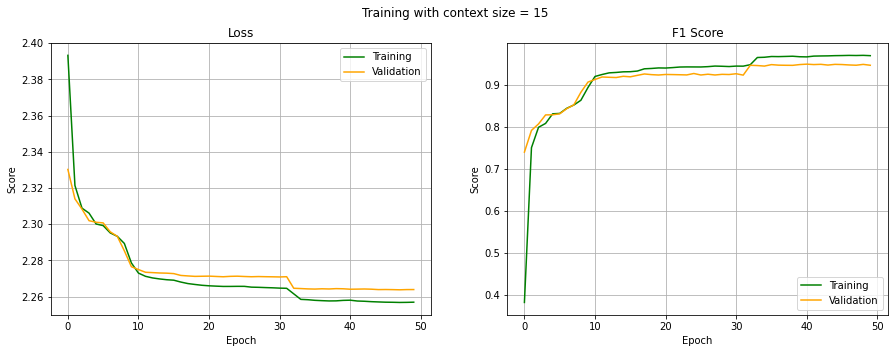

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9462, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9694, device='cuda:0'),
 tensor(0.9470, device='cuda:0'),
 tensor(0.9462, device='cuda:0'))

## Heatmap

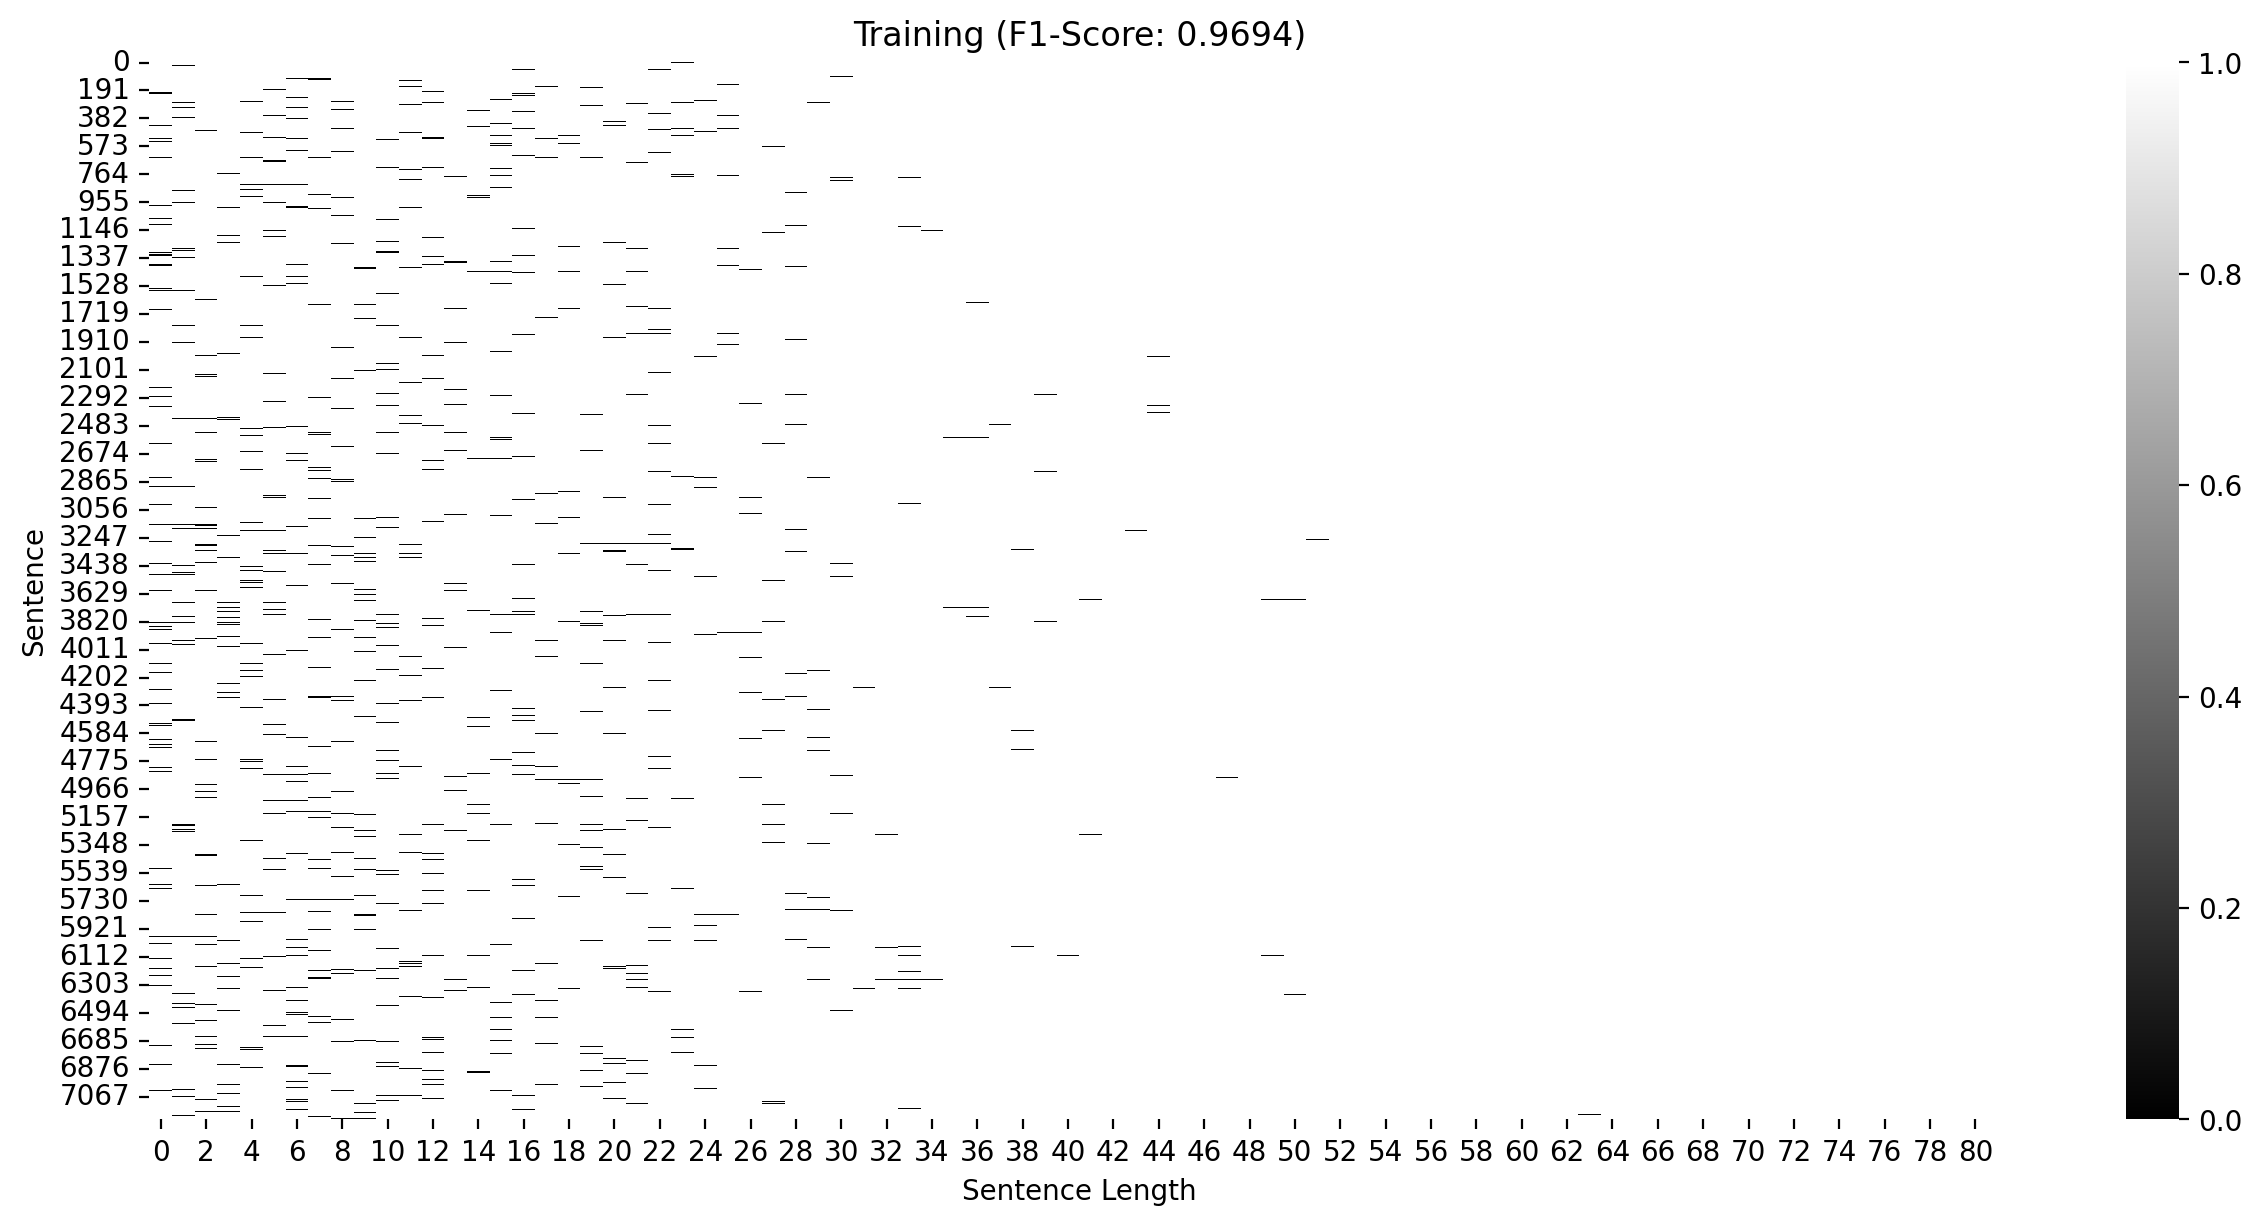

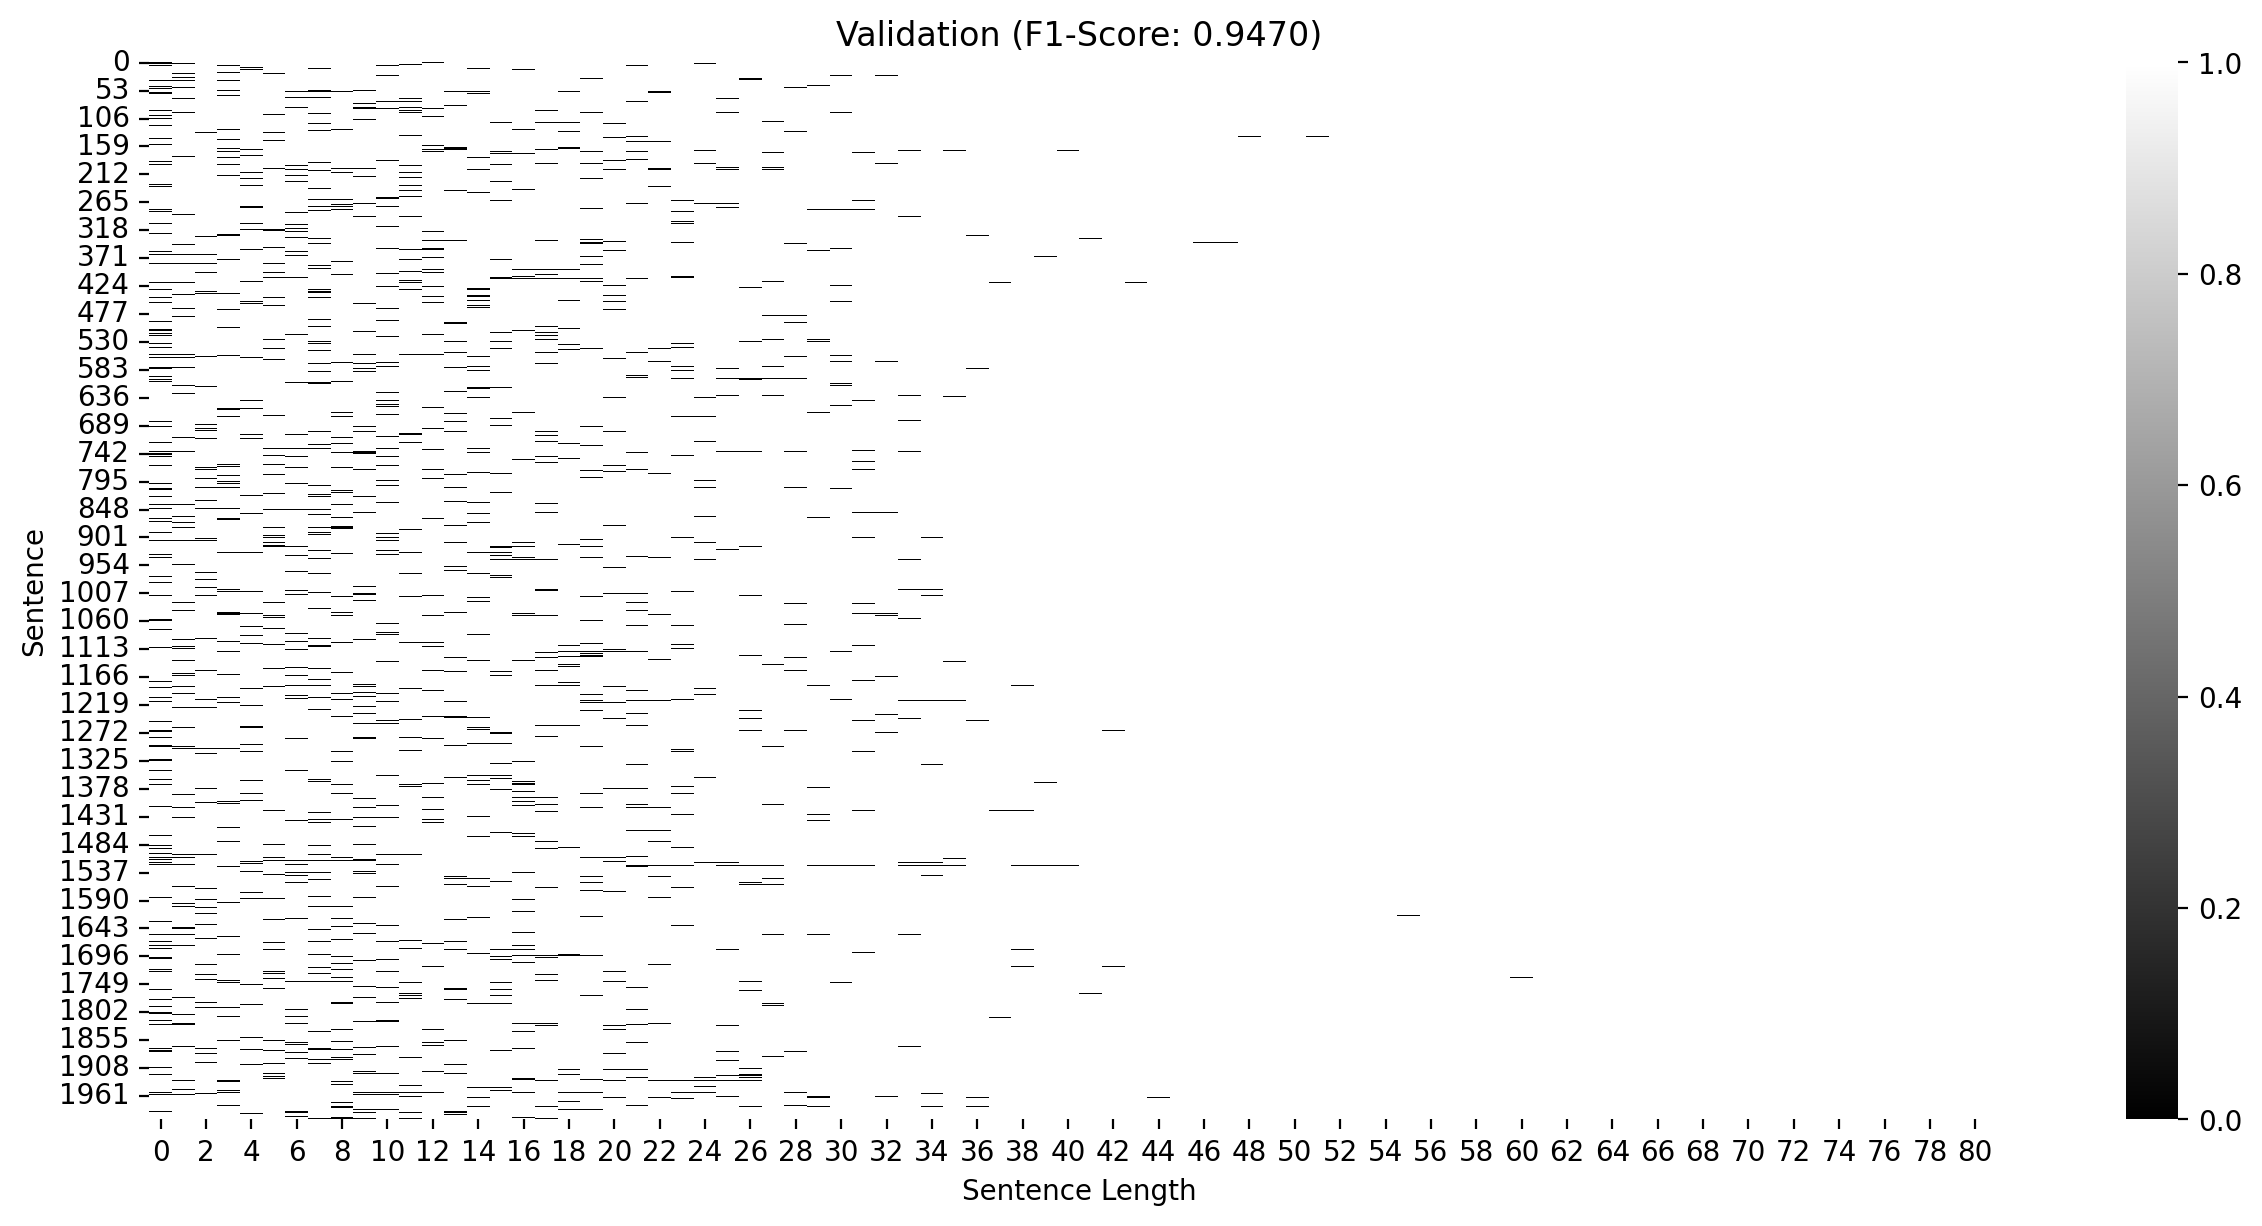

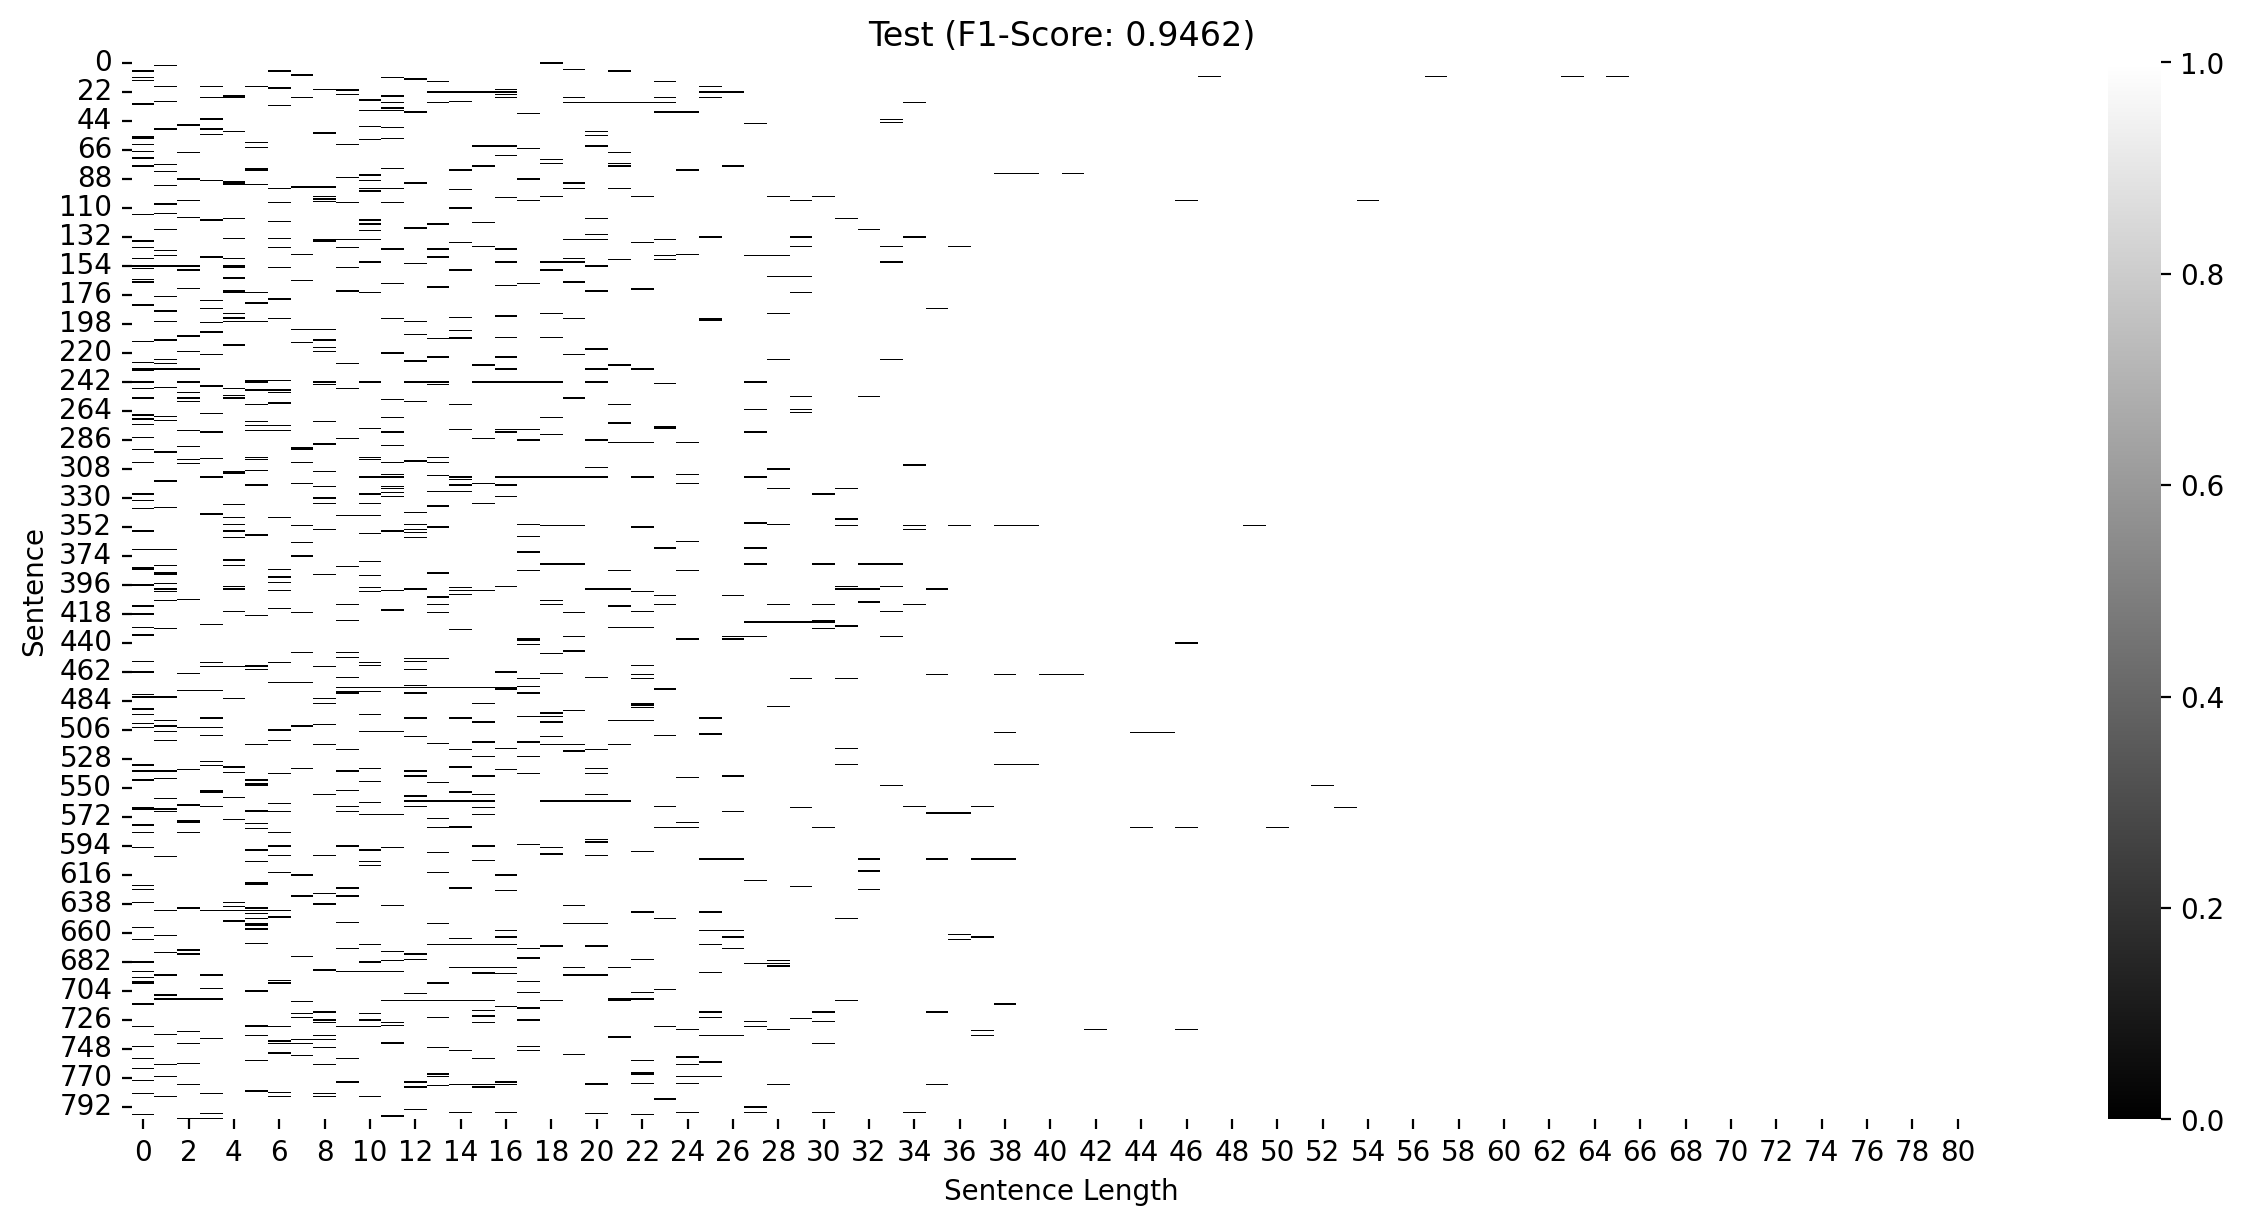

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


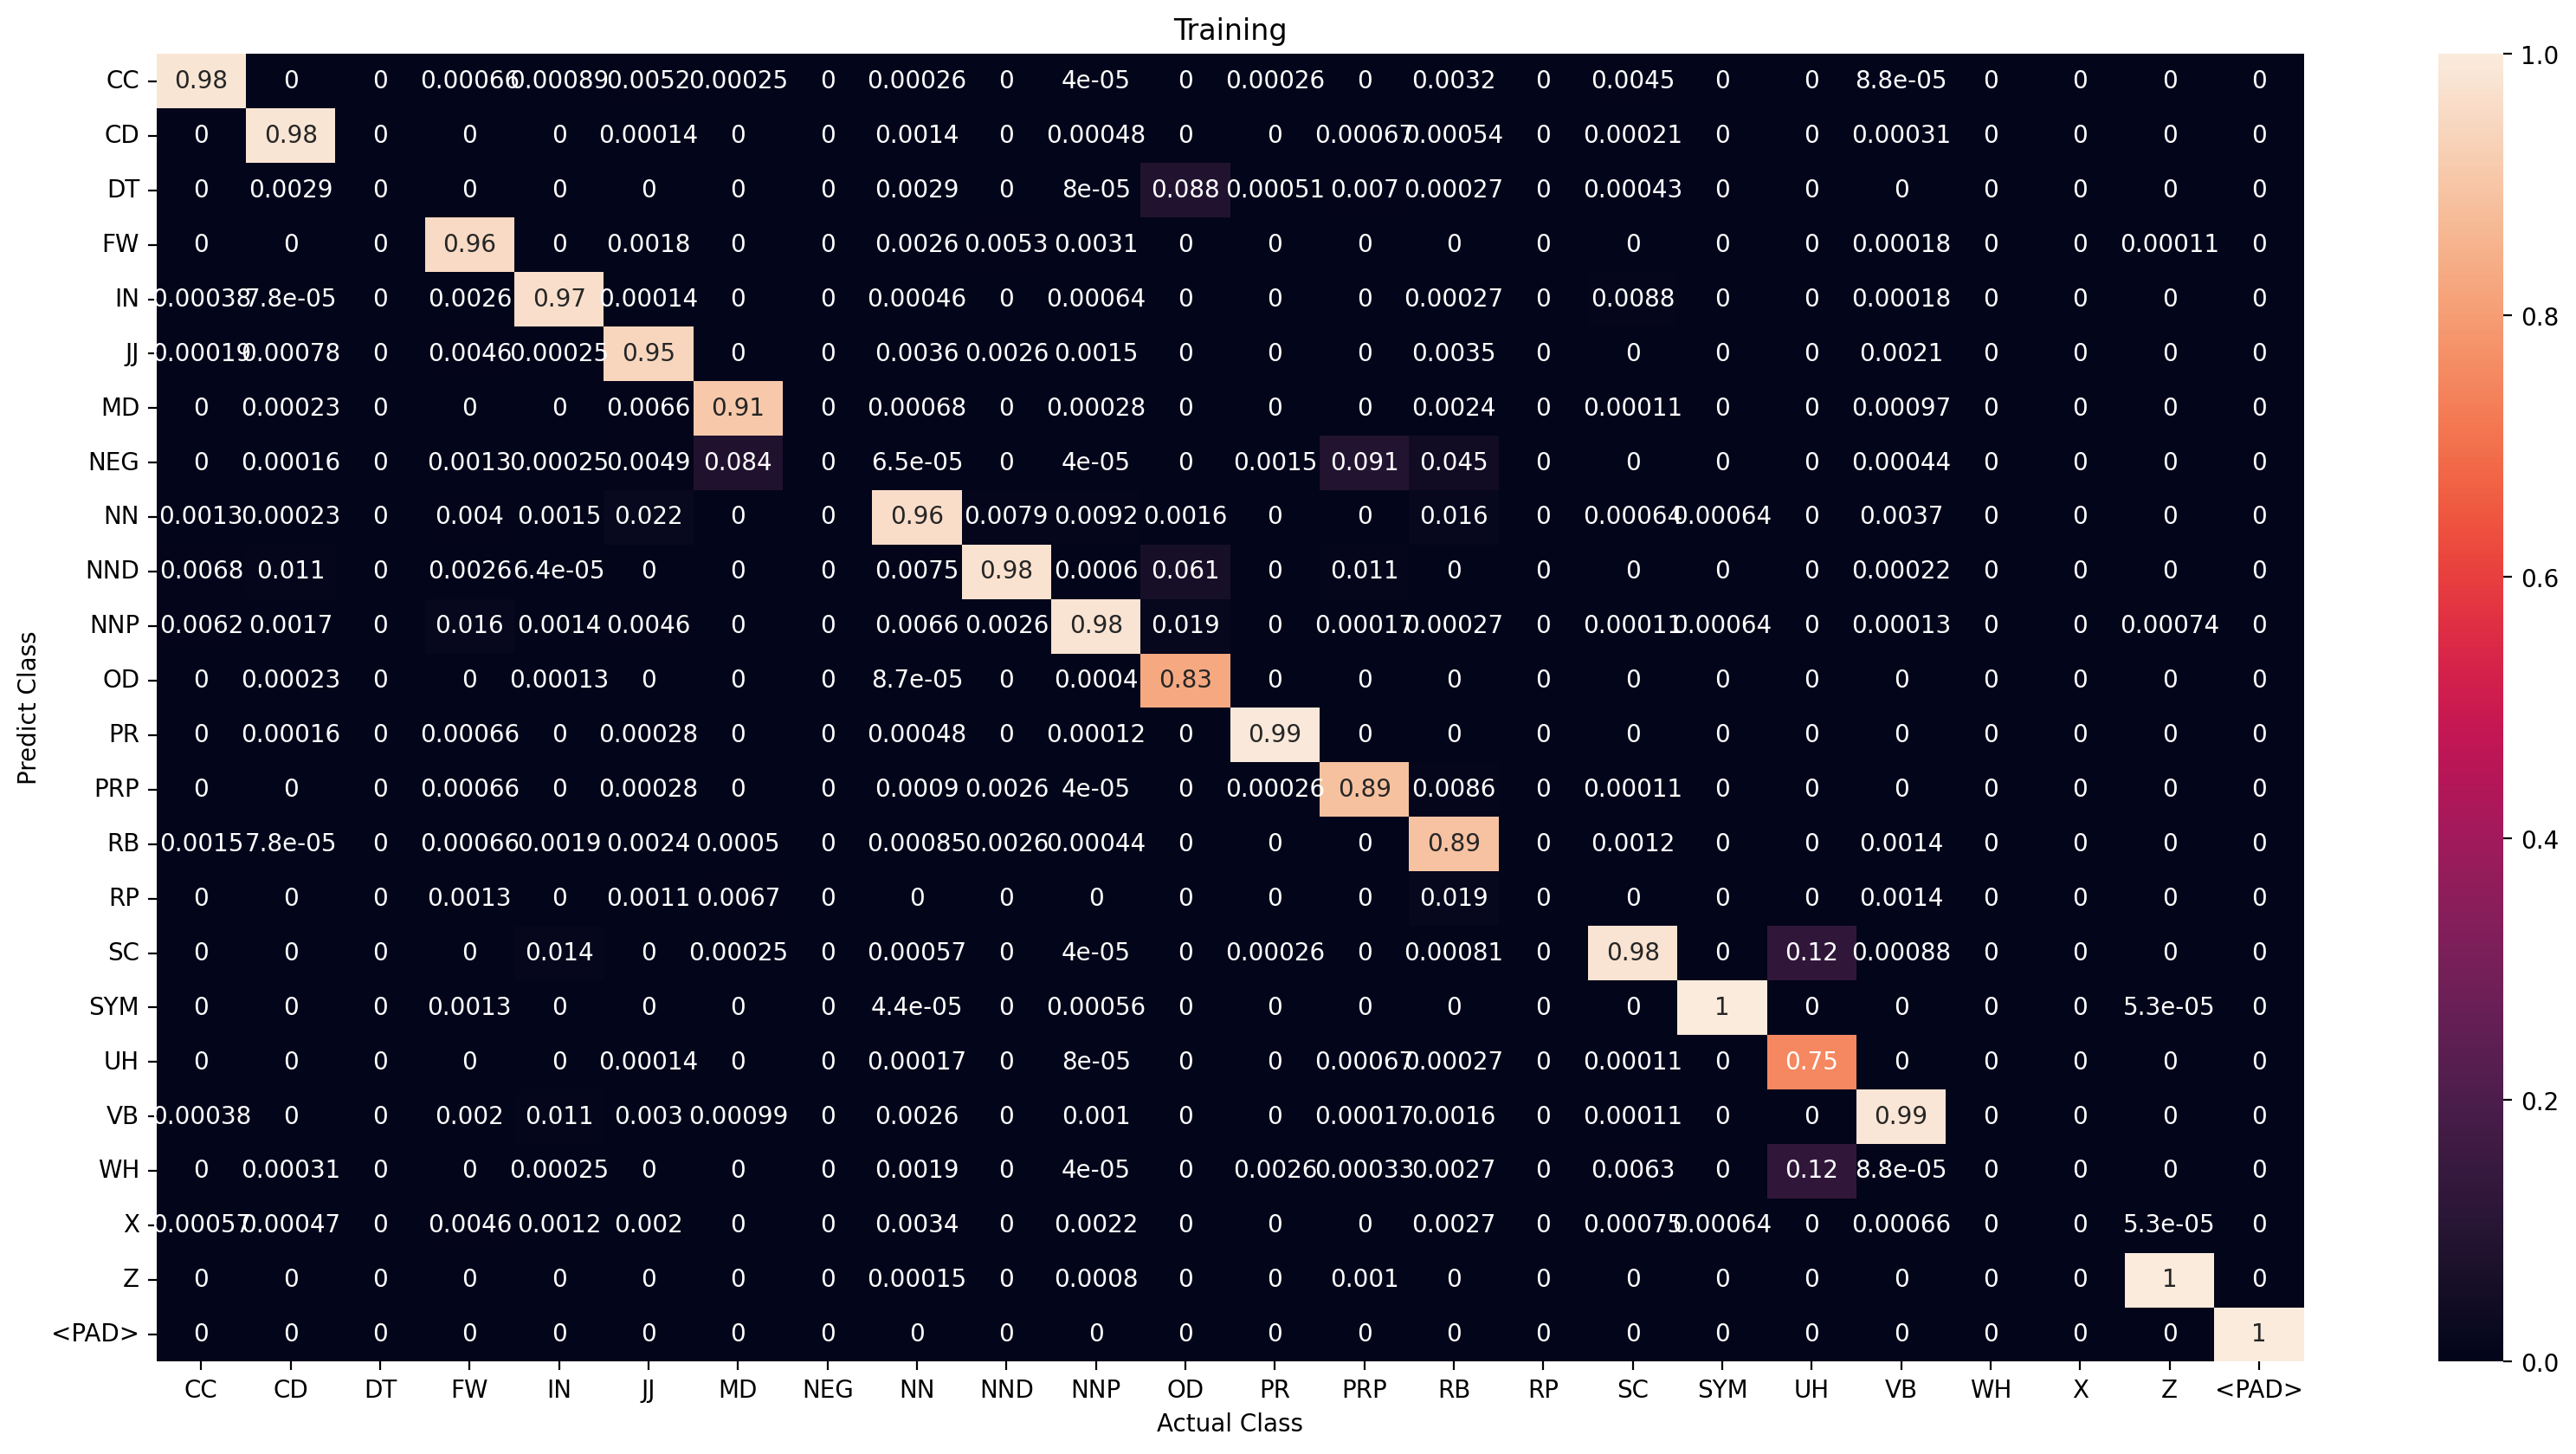

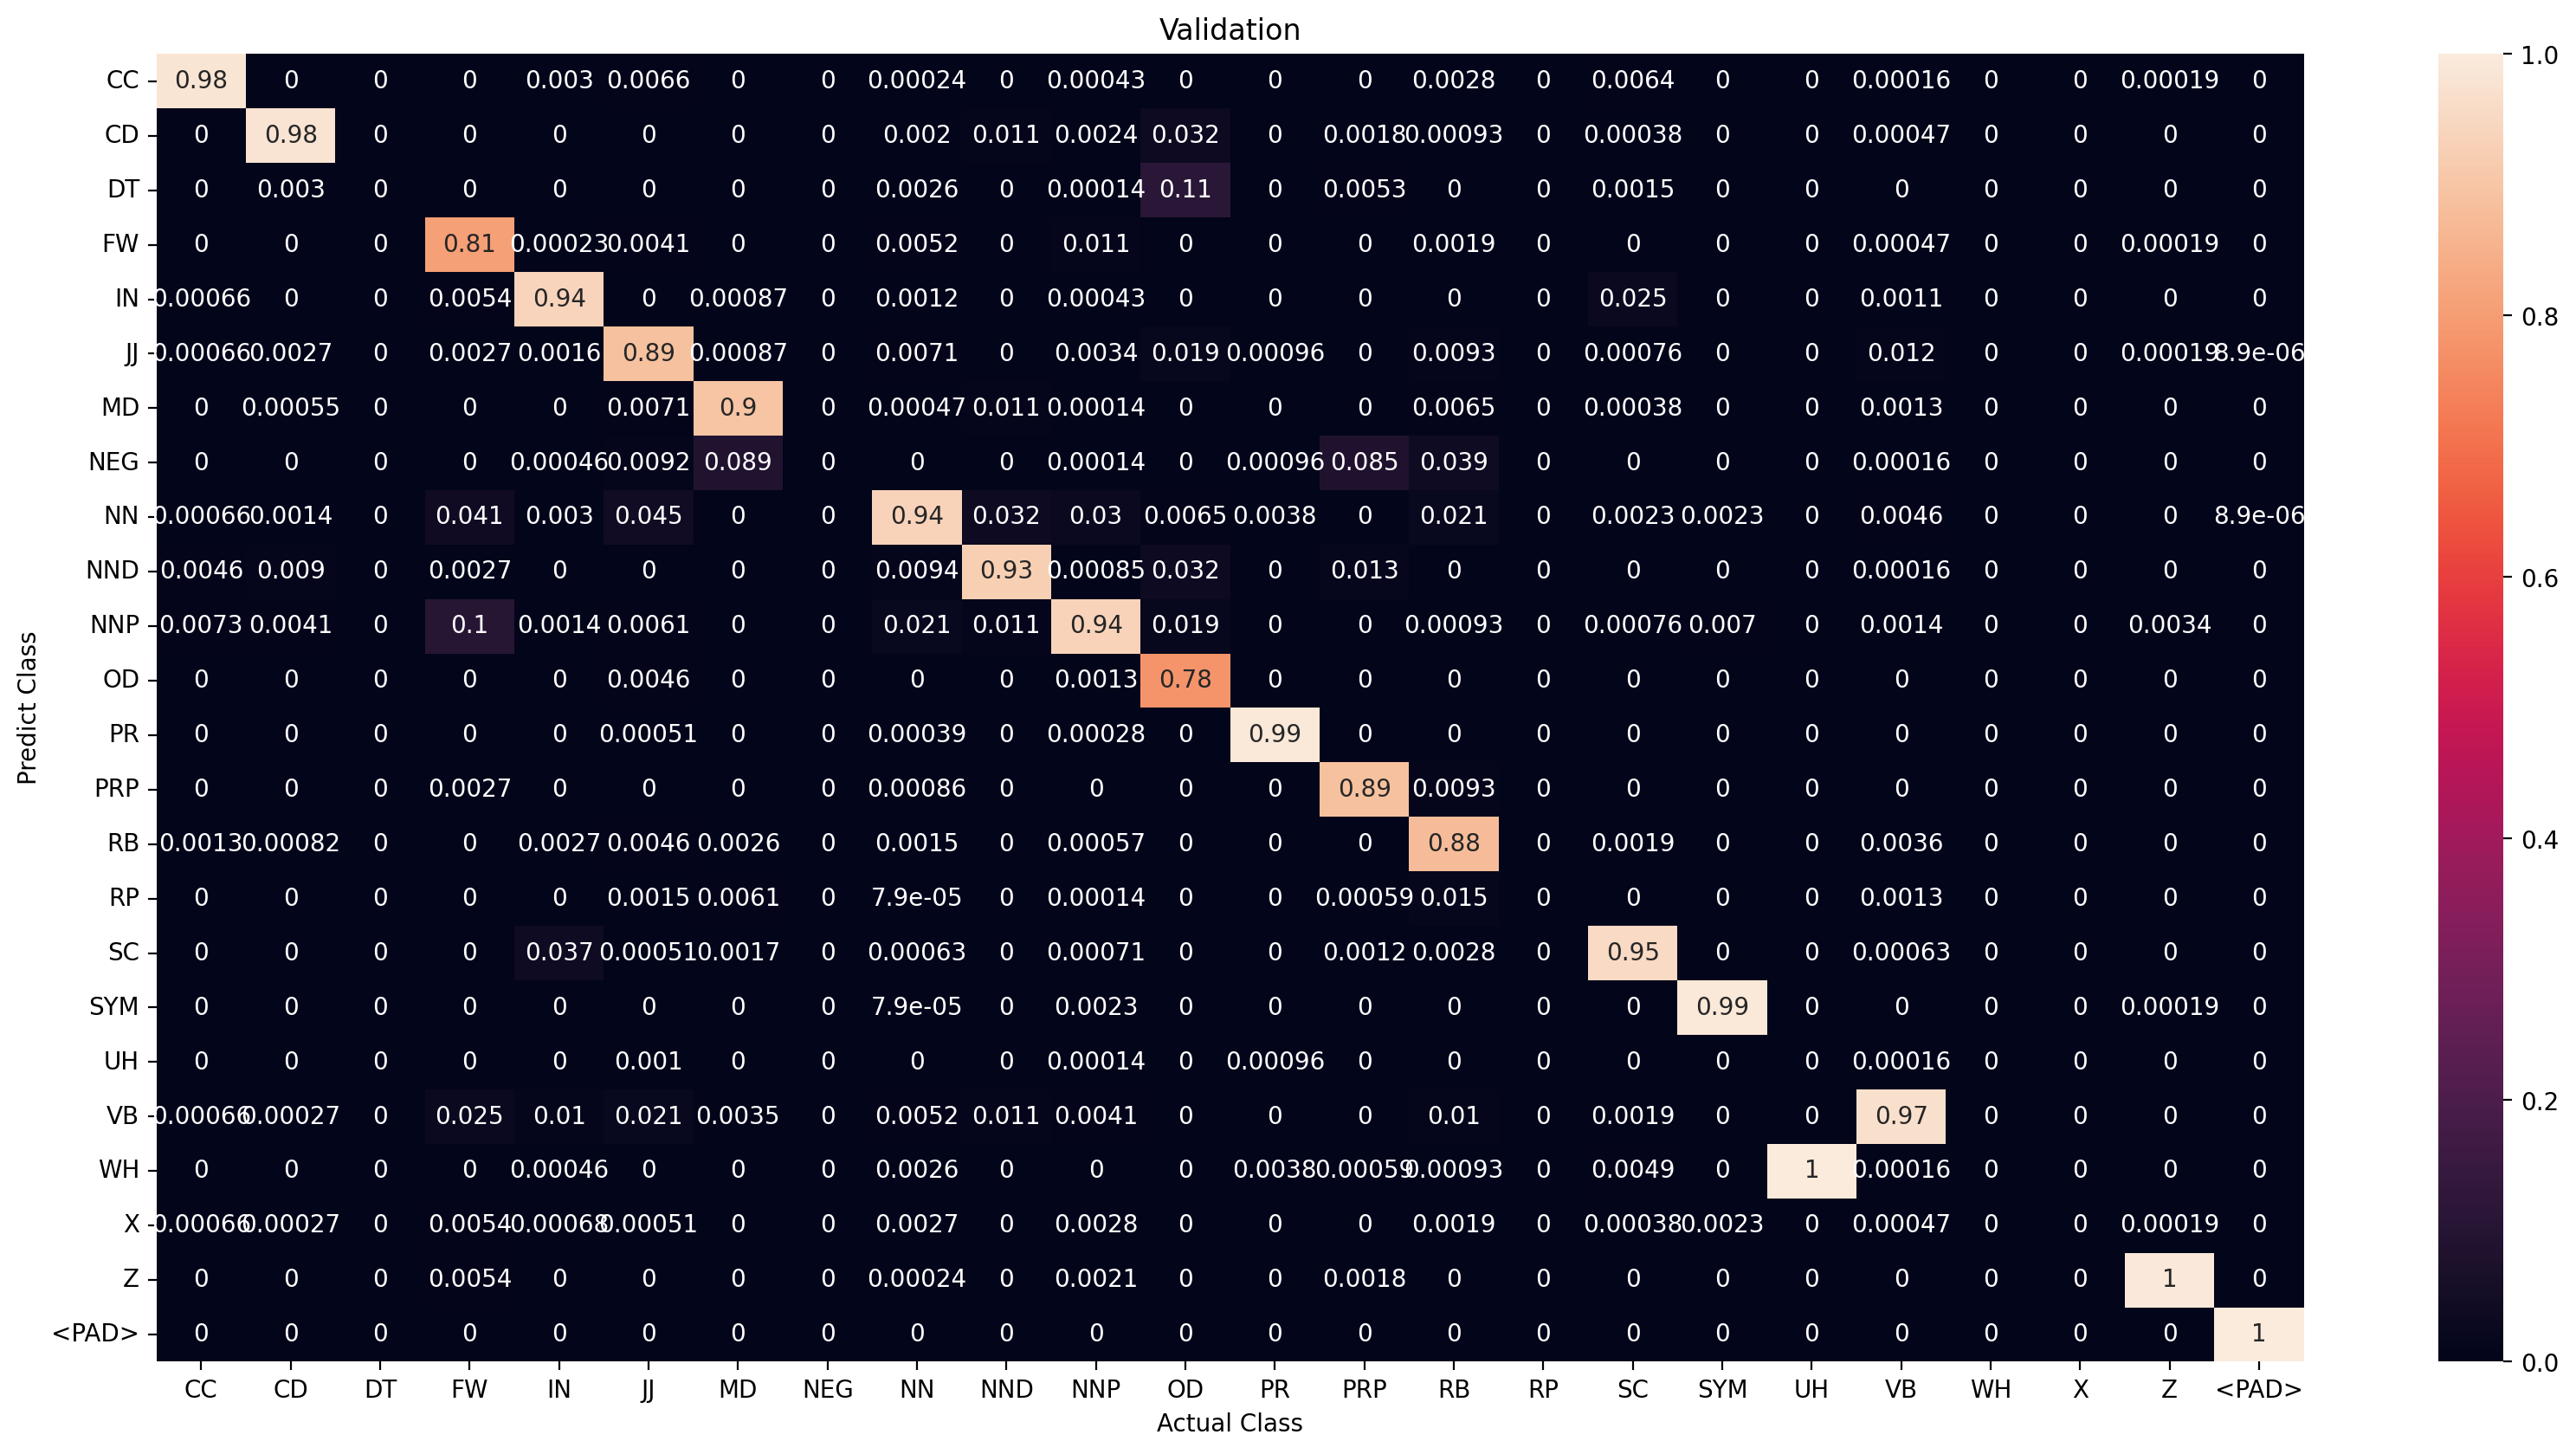

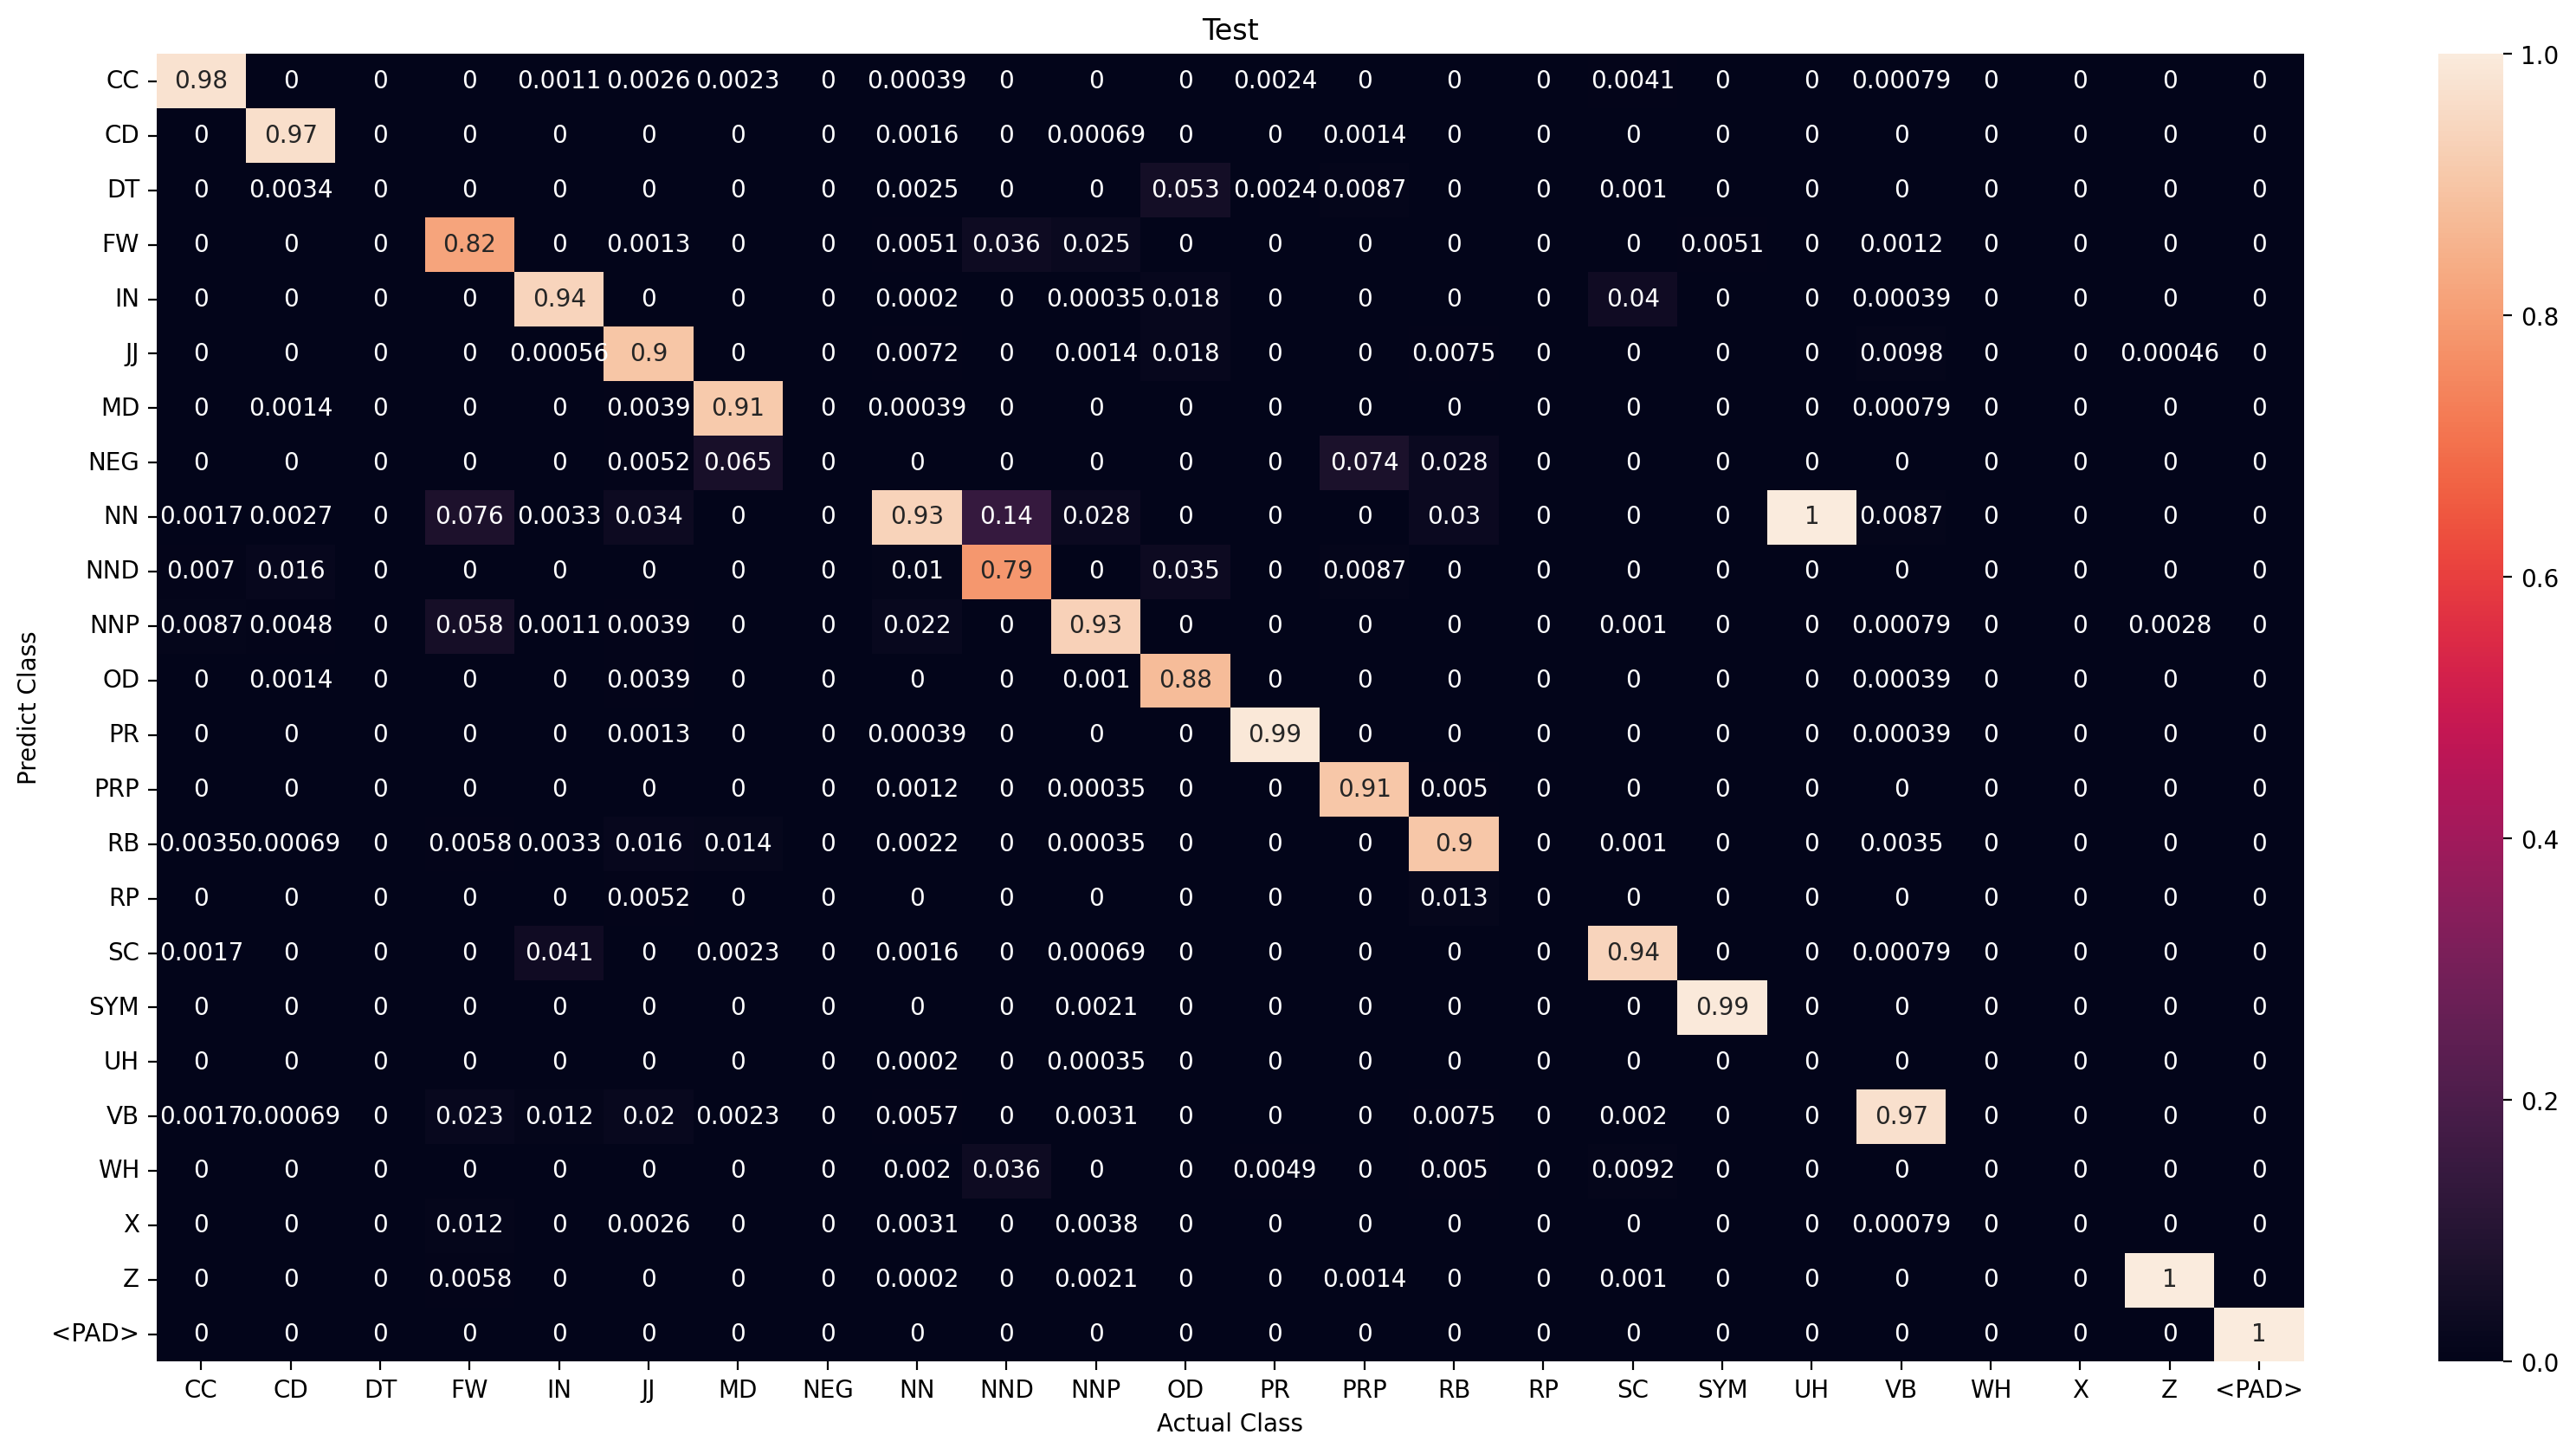

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5199       | CC    : 123      |
| CD    : 12758  | CD    : 12665      | CD    : 93       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1446       | FW    : 220      |
| IN    : 15371  | IN    : 15239      | IN    : 132      |
| JJ    : 6997   | JJ    : 6709       | JJ    : 288      |
| MD    : 3774   | MD    : 3654       | MD    : 120      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44091      | NN    : 581      |
| NND   : 1021   | NND   : 369        | NND   : 652      |
| NNP   : 24845  | NNP   : 24374      | NNP   : 471      |
| OD    : 541    | OD    : 522        | OD    : 19       |
| PR    : 3896   | PR    : 3866       | PR    : 30       |
| PRP   : 5408   | PRP   : 5328       | PRP   : 80       |
| RB    : 3463   | RB    : 3310       | RB    : 153      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11248
Wrong prediction            : 573
Percentage correct oov pred : 95.15269435749937

Validation
Number OOV token            : 3350
Correct prediction          : 2986
Wrong prediction            : 364
Percentage correct oov pred : 89.13432835820896

Test
Number OOV token            : 1391
Correct prediction          : 1240
Wrong prediction            : 151
Percentage correct oov pred : 89.14450035945363



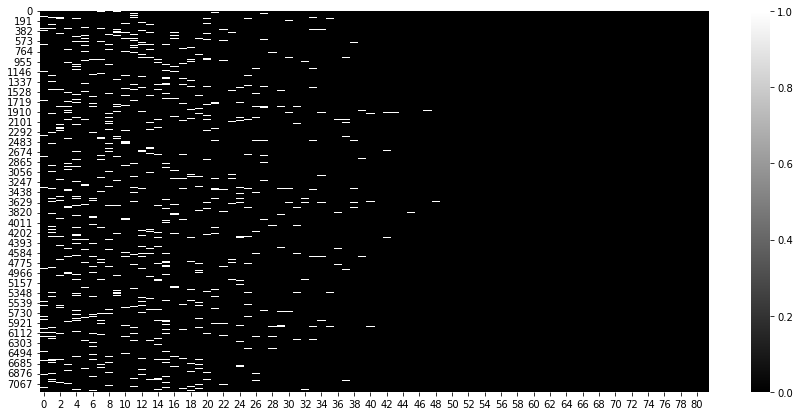

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

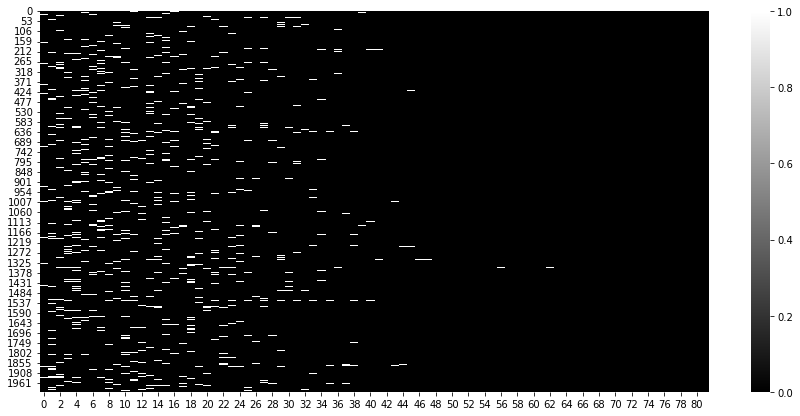

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

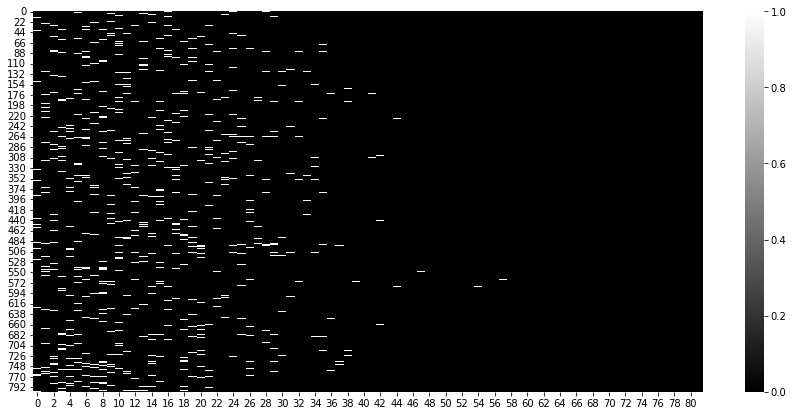

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);